# Mullins Sql 1

In [1]:
#push!(LOAD_PATH, "/Users/robert/bio/hmmids/")
include("/Users/robert/bio/BeNGS/NGSutilsFuncs.jl")
using HMMIDMethods
using HMMIDConfig
using States
using Observations
using NeedlemanWunsch
using Resolving
using CustomLDA
using PyPlot 
using Distributions

# Running HMMIDS on MullinsSql1 Data

In [2]:
data_dir = "data/MullinsSql1" 
original_data_file = "m54086_170411_231755.ccs.fastq"

"m54086_170411_231755.ccs.fastq"

In [3]:
# Filtering the data like ben likes it
usearch = "/Users/robert/bio/vsearch/vsearch-1.11.1-osx-x86_64/bin/vsearch"
filtered_data_file = "notebook_temp.fastq"
usearch_filter("$(data_dir)/$(original_data_file)", "$(data_dir)/$(filtered_data_file)", errorRate=0.001, minLength=2500)

Reading fastq file

vsearch v1.11.1_osx_x86_64, 8.0GB RAM, 4 cores
https://github.com/torognes/vsearch



 100%
39660 sequences kept (of which 0 truncated), 49216 sequences discarded.


In [7]:
templates = Dict()
#CCCGCGTGGCCTCCTGAATTATCCGCTCCGTCCGACGACTCACTATAACAGTGnnnnnnnnGTCATTGGTCTTAAAGGTACCTG
templates["10205509"] = "*CCGCTCCGTCCGACGACTCACTATAACAGTGnnnnnnnnGTCATTGGTCTTAAAGGTACCTG*"
#CCCGCGTGGCCTCCTGAATTATCCGCTCCGTCCGACGACTCACTATACAGATCNNNNNNNNGTCATTGGTCTTAAAGGTACCTG
templates["60101054"] = "*CCGCTCCGTCCGACGACTCACTATACAGATCnnnnnnnnGTCATTGGTCTTAAAGGTACCTG*"
#CCCGCGTGGCCTCCTGAATTATCCGCTCCGTCCGACGACTCACTATACTCAGANNNNNNNNGTCATTGGTCTTAAAGGTACCTG
templates["60406846"] = "*CCGCTCCGTCCGACGACTCACTATACTCAGAnnnnnnnnGTCATTGGTCTTAAAGGTACCTG*"
#universal_template = "*CCGCTCCGTCCGACGACTCACTATAnnnnnnnnnnnnnnGTCATTGGTCTTAAAGGTACCTGAGGT*"
print(length(first(values(templates))))

64

In [8]:
cfg = Configuration()
cfg.files = ["$(data_dir)/$(filtered_data_file)"]
cfg.filetype = fastq
cfg.start_inclusive = 0
cfg.end_inclusive = 69 
cfg.try_reverse = true
for (name, template) in templates
    push!(cfg.templates, Template(name, template))
end
cfg

HMMIDConfig.Configuration(String["data/MullinsSql1/notebook_temp2.fastq"],fastq::HMMIDConfig.FileType = 1,0,69,4,true,HMMIDConfig.Template[HMMIDConfig.Template("60101054",States.AbstractState[States.StartingState(),States.RepeatingAnyState(DNA_N),States.ObservableState(DNA_C),States.ObservableState(DNA_C),States.ObservableState(DNA_G),States.ObservableState(DNA_C),States.ObservableState(DNA_T),States.ObservableState(DNA_C),States.ObservableState(DNA_C),States.ObservableState(DNA_G)  …  States.ObservableState(DNA_A),States.ObservableState(DNA_G),States.ObservableState(DNA_G),States.ObservableState(DNA_T),States.ObservableState(DNA_A),States.ObservableState(DNA_C),States.ObservableState(DNA_C),States.ObservableState(DNA_T),States.ObservableState(DNA_G),States.RepeatingAnyState(DNA_N)]),HMMIDConfig.Template("60406846",States.AbstractState[States.StartingState(),States.RepeatingAnyState(DNA_N),States.ObservableState(DNA_C),States.ObservableState(DNA_C),States.ObservableState(DNA_G),States.

In [9]:
print("output/$(filtered_data_file)/")
if isdir("output/$(filtered_data_file)/")
    println("The directory already existed, DELETING! :P")
    rm("output/$(filtered_data_file)/", recursive=true)
end

output/notebook_temp2.fastq/

In [10]:
dir_dict = Dict()
my_output_func(source_file_name, template, tag, output_sequence, score) = HMMIDMethods.write_to_file_count_to_dict(dir_dict, source_file_name, template, tag, output_sequence, score)

function say(words)
    try
        run(`say $(words)`)
    end
end
say_print_func(count) = say("Processed $(count) sequences")

# This is the slow bit
process_file(cfg.files[1], cfg, my_output_func, print_every=1000, print_callback=say_print_func)
run(`say Done with HMMIDs`)

In [11]:
directories = collect(keys(dir_dict))

3-element Array{Any,1}:
 "data/MullinsSql1/notebook_temp2.fastq/60101054"
 "data/MullinsSql1/notebook_temp2.fastq/60406846"
 "data/MullinsSql1/notebook_temp2.fastq/10205509"

In [12]:
# Which template to analyse
analysing_template = 1;
template_name = basename(directories[analysing_template])

"60101054"

In [13]:
tag_dict = dir_dict[directories[analysing_template]]
delete!(tag_dict, "REJECTS")
tag_counts = tag_dict
tags = collect(keys(tag_dict))

818-element Array{Any,1}:
 "AGAGGCAA"  
 "AAGTTGGACT"
 "ATTTGACT"  
 "GCTGAATC"  
 "GTTTGACG"  
 "CACGGTTT"  
 "ATACAAT"   
 "CAGCTTAA"  
 "AGAGCTTTAT"
 "TAACTTCG"  
 "AATTCGA"   
 "ACACGGTT"  
 "ATTTCGGAC" 
 ⋮           
 "AGCACAGG"  
 "CTTTGAAT"  
 "CAGAGCA"   
 "AGATTAT"   
 "CGAATATG"  
 "ACTTTATGC" 
 "ATTCGATA"  
 "GCATGACTAG"
 "ATTAGGG"   
 "TTTAACCT"  
 "CTATGGTA"  
 "AAGCTTAAT" 

# Resolving which tags are real

In [14]:
tag_to_index, index_to_tag = tag_index_mapping(tags)
pacbio_error_rate = 0.005
recurse = 1
probabilities_array = prob_observed_tags_given_reals(tag_to_index, Resolving.PacBioErrorModel(pacbio_error_rate), recurse)
indexed_counts = index_counts(tag_counts, tag_to_index)

818-element Array{Int32,1}:
  6
  1
  6
  1
  1
  4
  3
  1
  1
  1
  1
  1
  2
  ⋮
 10
 63
  6
  1
  1
  1
  1
  1
  1
  1
  1
  1

In [15]:
most_likely_real_for_each_obs = CustomLDA.LDA(probabilities_array, indexed_counts)

818-element Array{Tuple{Int32,Float32},1}:
 (1,0.996758)  
 (2,0.999987)  
 (3,0.976486)  
 (4,0.999659)  
 (5,0.999039)  
 (6,0.997234)  
 (7,0.994839)  
 (8,0.99219)   
 (9,0.955534)  
 (10,0.995215) 
 (11,0.993792) 
 (12,0.983317) 
 (705,0.896101)
 ⋮             
 (807,0.999999)
 (808,0.99155) 
 (809,0.882452)
 (810,0.993923)
 (811,0.995037)
 (249,0.825994)
 (813,0.99757) 
 (814,1.0)     
 (815,0.999992)
 (816,0.999921)
 (817,0.999982)
 (818,0.961552)

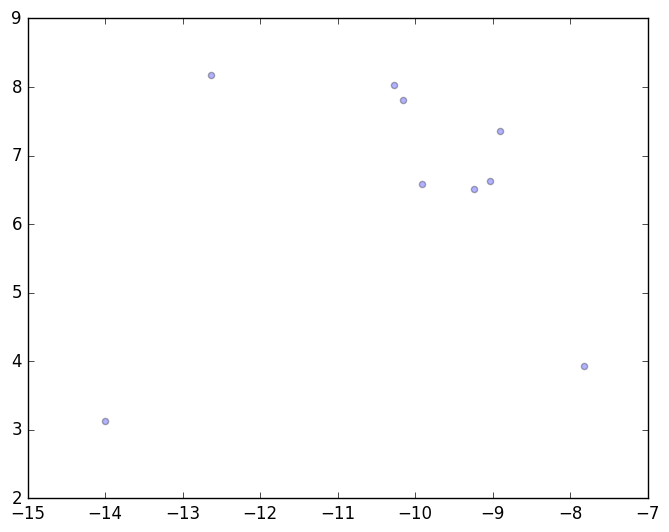

In [16]:
likely_real = []
probs = []
bin_sizes = []
for (observed_index, tuple) in enumerate(most_likely_real_for_each_obs)
    prob = tuple[2]
    if tag_counts[index_to_tag[observed_index]] <= 10
        prob = 0
    end
    if observed_index != tuple[1]
        prob = 0
    end
    if prob < .999
        continue
    end
    push!(likely_real, (prob, index_to_tag[observed_index]))
    push!(probs, log(1-prob))
    push!(bin_sizes, log(tag_counts[index_to_tag[observed_index]]))
end
scatter(probs, bin_sizes, alpha=0.3);

In [17]:
sort!(likely_real, by=x->tag_counts[x[2]])
println(length(likely_real))
for k in ([j[2] for j in likely_real])
    println("$(k)   \t$(tag_counts[k])")
end

9
GTTCTTAT   	23
CAATTTAT   	51
CCAAGGGT   	677
TACACTTG   	722
CAGAGCAA   	760
ACTTTATG   	1567
TTTGGACT   	2452
ATTTCGGA   	3051
GCGAATAG   	3563


# Getting Consensus Sequences

In [18]:
function consensusScoreAndViz(candidateRef,reads ; thresh = 0.7,shift = 3, intitle = "Consensus agreement.")
    #Need to add in code to handle deletions at the start and end of the candidate!
    alignments = [kmerSeededAlign(candidateRef,i) for i in reads];
    maps = [coords(i...) for i in alignments];
    matches = [freq([(alignments[i][2])[maps[i][k]:maps[i][k+shift]] for i in 1:length(maps)],candidateRef[k:k+shift]) for k in 1:length(candidateRef)-shift];
    frontStrCol = freq([degapString((alignments[j][2])[1:maps[j][1]-1]) for j in 1:length(maps)],"")
    endStrCol = freq([degapString((alignments[j][2])[maps[j][end]+1:end]) for j in 1:length(maps)],"")
    w, h = plt[:figaspect](0.1)
    figure(figsize=(w,h))
    plot(1:length(matches)+2,vcat([frontStrCol],matches,[endStrCol]))
    ax = gca()
    ax[:set_xlim]([-10,length(matches)+12])
    ax[:set_ylim]([0,1])
    mean_score = mean(vcat([frontStrCol],matches,[endStrCol]))
    title("$(intitle) - $(mean_score)")
    xlabel("Consensus Position")
    ylabel("Agreement")
    return mean_score
end

consensusScoreAndViz (generic function with 1 method)

In [20]:
directory = "$(pwd())/output/$(filtered_data_file)/$(template_name)/"
consensuses = Dict()
consensus_scores = Dict()

for (prob, tag) in likely_real
    filename = "$(directory)$(tag).fastq"
    println("$(tag) - $(tag_counts[tag])")
    seqs = []
    for sequence in Nucleotides.FastqIterator(filename)
        push!(seqs, join(map(string, sequence.seq)))
    end
    strings = Array{String}(seqs)
    consensuses[tag] = consensusSeq(strings)
    consensus_scores[tag] = consensusScoreAndViz(consensuses[tag], seqs, intitle="$(tag) - $(tag_counts[tag])")
    println(consensus_scores[tag])
end
run(`say Done`)

GTTCTTAT - 23
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching produced inconsistent ordering. Consider a larger word size. Returning full DP alignment for now.
Notice: Word matching prod

LoadError: LoadError: InterruptException:
while loading In[20], in expression starting on line 5

In [21]:
x = [log(tag_counts[x[2]]) for x in likely_real]
y = [consensus_scores[x[2]] for x in likely_real]
scatter(x, y);

LoadError: LoadError: KeyError: key "CAGAGCAA" not found
while loading In[21], in expression starting on line 2

In [22]:
names = []
seqs = []
for (resolving_score, tag) in likely_real
    #if (consensus_scores[tag] > .97)
    push!(names, "$(tag)_$(tag_counts[tag])_$(round(consensus_scores[tag],4))")
    push!(seqs, consensuses[tag])
    #end
end
filename = "$(data_dir)/$(template_name)_consensus.fasta"
println("Writing to $(filename)")
write_fasta_with_names(filename, names, Array{DNASequence}(seqs))

LoadError: LoadError: KeyError: key "CAGAGCAA" not found
while loading In[22], in expression starting on line 3